# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

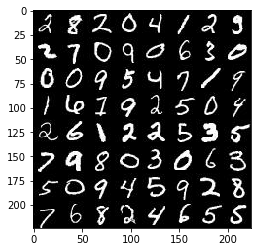

In [2]:
show_n_images = 8*8

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

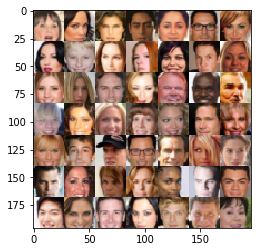

In [3]:
show_n_images = 7*7

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    images_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    

    return images_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [92]:
#Adding the alpha argument to the discriminator function since this is required for Leaky ReLU
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    #Setting kernel size a variable to tweak it and observe the outputs
    kernel_size = 5 #3,5,7
    
    
    #Create the variable scope
    with tf.variable_scope('discriminator', reuse=reuse):
        #As per the description in the problem statement, the images will be of size 28x28

        #First convolution will transform them to 64 depth, strides=1 so we don't reduce height and width
        img0 = tf.layers.conv2d(images, 64, kernel_size, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu0 = tf.maximum(alpha * img0, img0)
        # 28x28x64
        
        #First convolution will transform them to 64x64
        img1 = tf.layers.conv2d(relu0, 128, kernel_size, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_img1 = tf.layers.batch_normalization(img1, training=True)
        relu1 = tf.maximum(alpha * bn_img1, bn_img1)
        # 14x14x128
        
        img2 = tf.layers.conv2d(relu1, 256, kernel_size, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_img2 = tf.layers.batch_normalization(img2, training=True)
        relu2 = tf.maximum(alpha * bn_img2, bn_img2)
        # 7x7x256
        
        img3 = tf.layers.conv2d(relu2, 512, kernel_size, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_img3 = tf.layers.batch_normalization(img3, training=True)
        relu3 = tf.maximum(alpha * bn_img3, bn_img3)
        # Following the logic here we would get 3.5x3.5x256. However, with padding 'same' the 
        #tf.layers.conv2d formula is:
        # out_height = ceil(float(in_height) / float(strides[1])) --> ceil(7/2) --> 4
        # out_width = ceil(float(in_width) / float(strides[2]))  --> ceil(7/2) --> 4
        # therefore, output is 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [93]:
#Adding the alpha argument to the discriminator function since this is required for Leaky ReLU
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    #Setting kernel size a variable to tweak it and observe the outputs
    kernel_size = 5 #3,5,7

    #Reuse should be the opposite of training. This means that when is_train = False then reuse=True and viceversa 
    reuse = not is_train
    
    #Create the variable scope
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        #The first transformation here will be to 4x4x512
        z1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        z1 = tf.reshape(z1, (-1, 4, 4, 512))
        z1 = tf.layers.batch_normalization(z1, training=is_train)
        z1 = tf.maximum(alpha * z1, z1)
        # The shape of z1 is 4x4x512

        #To move from 4x4x512 to 7x7x256 we will need to use kernel_size = 4 and stride = 1 with padding valid
        #To get to these values I used the formulas available in the documentation and tested it out
        z2 = tf.layers.conv2d_transpose(z1, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        z2 = tf.layers.batch_normalization(z2, training=is_train)
        z2 = tf.maximum(alpha * z2, z2)
        #The shape of the tensor is 7x7x256
        
        
        z3 = tf.layers.conv2d_transpose(z2, 128, kernel_size, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        z3 = tf.layers.batch_normalization(z3, training=is_train)
        z3 = tf.maximum(alpha * z3, z3)
        #With padding = same only the stride matters to the shape is 14x14x128
        
        #Changing stride=1 so the shape is preserved
        z4 = tf.layers.conv2d_transpose(z3, 64, kernel_size, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        z4 = tf.layers.batch_normalization(z4, training=is_train)
        z4 = tf.maximum(alpha * z4, z4)
        #With padding = same only the stride matters to the shape is 14x14x64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(z4, out_channel_dim, kernel_size, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xoutput_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [94]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    #Label smoother:
    smooth = 0.1
    
    g_out = generator(input_z, out_channel_dim, alpha=alpha)
    
    #Next we will get the outputs and logits of the discriminator using the real image first and then the 
    #image generated by the generator above
    d_out_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True, alpha=alpha)
    
    #Compute the loss both for the real outputs and the generated outputs.
    #Note: the real images will always be evaluated against True (tf.ones_like) and the discriminator always
    #evaluated against False (tf.zeros_like)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_out_real)*(1-smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_out_fake)*(1-smooth)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_out_fake)*(1-smooth)))

    #Combine the losses for the discriminator:
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [95]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [96]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [98]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    #Stats for training
    print_every = 20
    show_every = 200
    n_images_sample = 49
    
    #First get the inputs: decomposing data_shape into its different elements
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    #Get the discriminator and generator loss models
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=alpha)

    #Get the discriminator and generator optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
    
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            
                #Rescale batch_images to (-1,1) since they are returned in (-0.5,0.5) and tanh outputs (-1,1)
                batch_images = batch_images * 2

                # Run optimizers, as recommended in the notebook, running the generator optimization twice
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images_sample, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.9803... Generator Loss: 0.4936
Epoch 1/2... Discriminator Loss: 1.3609... Generator Loss: 0.9969
Epoch 1/2... Discriminator Loss: 1.6860... Generator Loss: 0.7200
Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.7546... Generator Loss: 0.7584
Epoch 1/2... Discriminator Loss: 1.5449... Generator Loss: 0.8037
Epoch 1/2... Discriminator Loss: 1.4789... Generator Loss: 0.7716
Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 0.8783
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.6953
Epoch 1/2... Discriminator Loss: 1.4463... Generator Loss: 0.5551


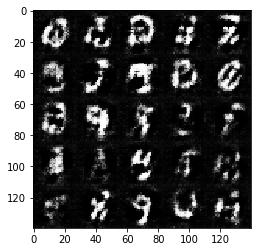

Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 1.0748
Epoch 1/2... Discriminator Loss: 1.3432... Generator Loss: 0.6983
Epoch 1/2... Discriminator Loss: 1.2279... Generator Loss: 0.9128
Epoch 1/2... Discriminator Loss: 1.2963... Generator Loss: 1.0007
Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 0.9770
Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 0.6854
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 0.8134
Epoch 1/2... Discriminator Loss: 1.2613... Generator Loss: 0.7776
Epoch 1/2... Discriminator Loss: 1.3403... Generator Loss: 1.0208
Epoch 1/2... Discriminator Loss: 1.3566... Generator Loss: 1.1052


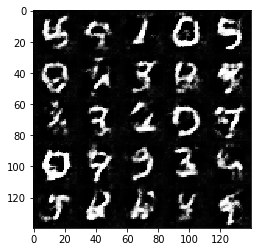

Epoch 1/2... Discriminator Loss: 1.3065... Generator Loss: 0.6669
Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 1.2414
Epoch 1/2... Discriminator Loss: 1.3331... Generator Loss: 0.6543
Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.6341
Epoch 1/2... Discriminator Loss: 1.2970... Generator Loss: 0.8430
Epoch 1/2... Discriminator Loss: 1.3314... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.6019
Epoch 1/2... Discriminator Loss: 1.3263... Generator Loss: 0.7806
Epoch 1/2... Discriminator Loss: 1.4797... Generator Loss: 0.5213
Epoch 1/2... Discriminator Loss: 1.2349... Generator Loss: 0.8567


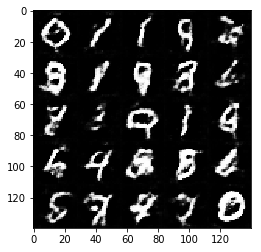

Epoch 1/2... Discriminator Loss: 1.3854... Generator Loss: 0.6717
Epoch 1/2... Discriminator Loss: 1.5193... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.6709
Epoch 1/2... Discriminator Loss: 1.4389... Generator Loss: 1.1620
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.6541
Epoch 1/2... Discriminator Loss: 1.2760... Generator Loss: 0.9527
Epoch 1/2... Discriminator Loss: 1.2838... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 1.4013... Generator Loss: 0.5693
Epoch 1/2... Discriminator Loss: 1.4082... Generator Loss: 0.5870
Epoch 1/2... Discriminator Loss: 1.2672... Generator Loss: 1.1305


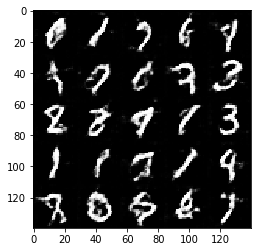

Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 0.5406
Epoch 1/2... Discriminator Loss: 1.3452... Generator Loss: 0.6102
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 1.1367
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.7112
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 0.6195
Epoch 1/2... Discriminator Loss: 1.4817... Generator Loss: 0.8680
Epoch 2/2... Discriminator Loss: 1.2760... Generator Loss: 0.6871
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.6278
Epoch 2/2... Discriminator Loss: 1.3666... Generator Loss: 0.9322
Epoch 2/2... Discriminator Loss: 1.2991... Generator Loss: 0.7573


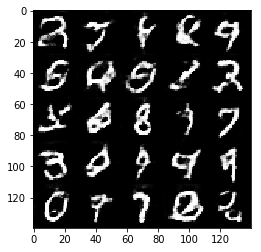

Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 1.3348... Generator Loss: 0.6230
Epoch 2/2... Discriminator Loss: 1.2902... Generator Loss: 0.6194
Epoch 2/2... Discriminator Loss: 1.4664... Generator Loss: 0.5285
Epoch 2/2... Discriminator Loss: 1.2599... Generator Loss: 0.7326
Epoch 2/2... Discriminator Loss: 1.4482... Generator Loss: 0.5719
Epoch 2/2... Discriminator Loss: 1.4181... Generator Loss: 0.5253
Epoch 2/2... Discriminator Loss: 1.4159... Generator Loss: 0.5463
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 0.6625
Epoch 2/2... Discriminator Loss: 1.4297... Generator Loss: 0.5988


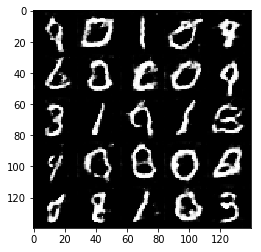

Epoch 2/2... Discriminator Loss: 1.4158... Generator Loss: 1.1011
Epoch 2/2... Discriminator Loss: 1.4127... Generator Loss: 0.5411
Epoch 2/2... Discriminator Loss: 1.3744... Generator Loss: 0.9882
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 0.6725
Epoch 2/2... Discriminator Loss: 1.2436... Generator Loss: 0.8427
Epoch 2/2... Discriminator Loss: 1.2092... Generator Loss: 0.7242
Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 0.6548
Epoch 2/2... Discriminator Loss: 1.2373... Generator Loss: 0.8202
Epoch 2/2... Discriminator Loss: 1.2040... Generator Loss: 0.7166
Epoch 2/2... Discriminator Loss: 1.6012... Generator Loss: 0.4731


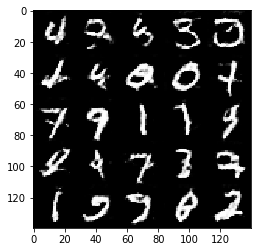

Epoch 2/2... Discriminator Loss: 1.1873... Generator Loss: 0.7746
Epoch 2/2... Discriminator Loss: 1.7122... Generator Loss: 0.4362
Epoch 2/2... Discriminator Loss: 1.5409... Generator Loss: 0.4945
Epoch 2/2... Discriminator Loss: 1.3479... Generator Loss: 0.6461
Epoch 2/2... Discriminator Loss: 1.3229... Generator Loss: 0.6153
Epoch 2/2... Discriminator Loss: 2.0944... Generator Loss: 0.3778
Epoch 2/2... Discriminator Loss: 1.6308... Generator Loss: 0.4646
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 0.6984
Epoch 2/2... Discriminator Loss: 1.5305... Generator Loss: 1.5480
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.6156


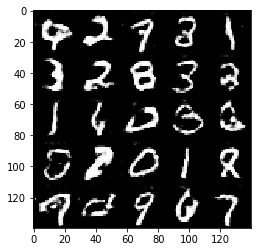

Epoch 2/2... Discriminator Loss: 1.2333... Generator Loss: 0.7585
Epoch 2/2... Discriminator Loss: 1.2250... Generator Loss: 0.8050
Epoch 2/2... Discriminator Loss: 1.5009... Generator Loss: 0.4947
Epoch 2/2... Discriminator Loss: 2.1331... Generator Loss: 0.3697
Epoch 2/2... Discriminator Loss: 1.3182... Generator Loss: 0.6740
Epoch 2/2... Discriminator Loss: 1.0147... Generator Loss: 1.4726
Epoch 2/2... Discriminator Loss: 1.9566... Generator Loss: 0.3927
Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 1.5007... Generator Loss: 0.5068
Epoch 2/2... Discriminator Loss: 1.4718... Generator Loss: 0.5058


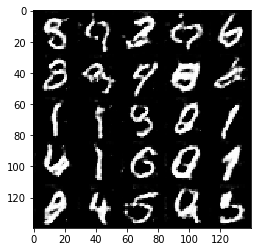

Epoch 2/2... Discriminator Loss: 1.1813... Generator Loss: 0.9455
Epoch 2/2... Discriminator Loss: 1.1519... Generator Loss: 0.8096
Epoch 2/2... Discriminator Loss: 1.2691... Generator Loss: 0.6474


In [58]:
#Tested batch_size of 32, 64,128 and 256. 64 yielded the images with good quality (no objective assessment, 
# just me looking at the samples) and faster than 32

#Tried with an without label smoothing (i.e smooth =0 and smooth = 0.1) and the results seem to have converged faster
#and with higher quality using label smoothing
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))


with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha=alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 5.0165
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.9018
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 3.4475
Epoch 1/1... Discriminator Loss: 0.7347... Generator Loss: 2.6992
Epoch 1/1... Discriminator Loss: 0.6490... Generator Loss: 2.1124
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 2.0289
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.9562
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 1.2212
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 1.0194


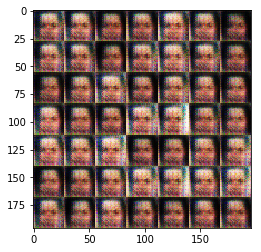

Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 1.6464
Epoch 1/1... Discriminator Loss: 1.8232... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 1.6678... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 1.0218


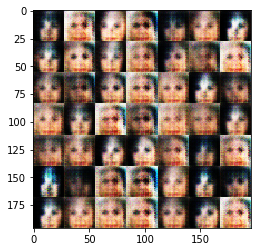

Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.0018
Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 1.5565
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 1.2071
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.3456
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 1.0396


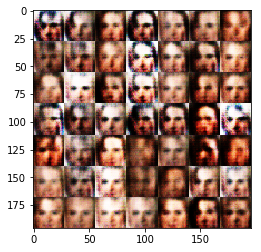

Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 1.6105
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 1.0769


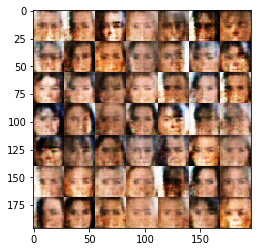

Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 1.0112
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.7985


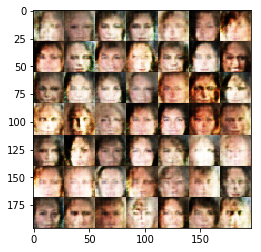

Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 1.0569


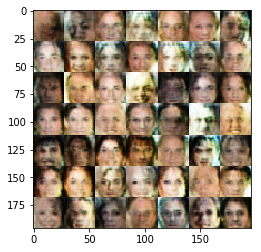

Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 1.7012... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.9066


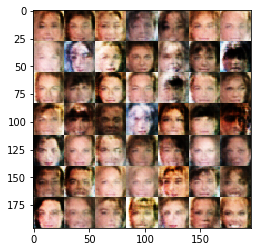

Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.5921


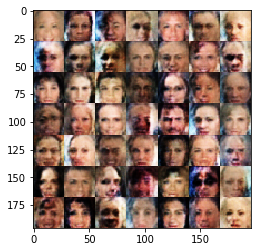

Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.5222
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7857


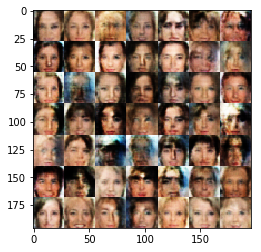

Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.5649... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.6100


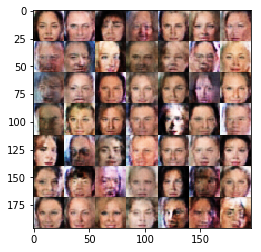

Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.5439... Generator Loss: 0.5377
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.6081... Generator Loss: 0.5125


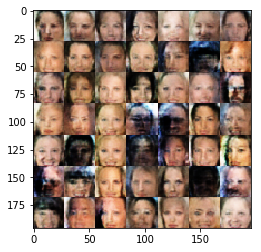

Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.8912


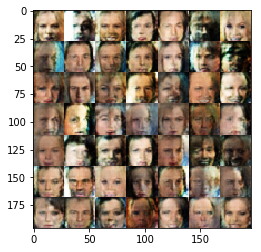

Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.5761... Generator Loss: 0.4825
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8377


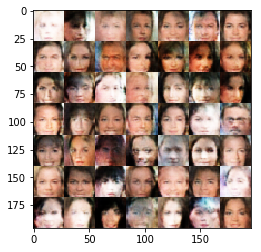

Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.5505


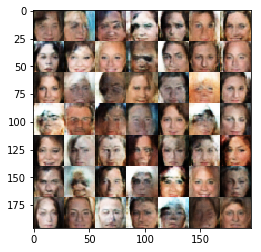

Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 1.2463
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.5418... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.5327


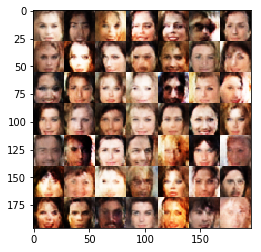

Epoch 1/1... Discriminator Loss: 1.6083... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 1.6181... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6033


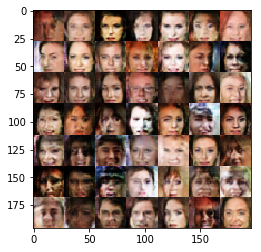

Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.5323
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.5281
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 1.1558
Epoch 1/1... Discriminator Loss: 1.6385... Generator Loss: 0.4661
Epoch 1/1... Discriminator Loss: 1.6392... Generator Loss: 0.4779


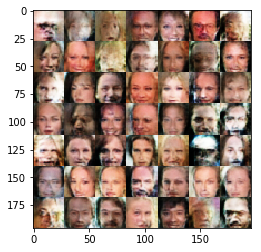

Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.5695... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.4987
Epoch 1/1... Discriminator Loss: 1.6595... Generator Loss: 0.4488
Epoch 1/1... Discriminator Loss: 1.7437... Generator Loss: 0.4274
Epoch 1/1... Discriminator Loss: 1.5911... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.5269
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.6047


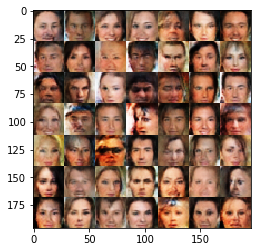

Epoch 1/1... Discriminator Loss: 1.6192... Generator Loss: 0.4583
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 1.6028... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.4688
Epoch 1/1... Discriminator Loss: 1.7362... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.0499


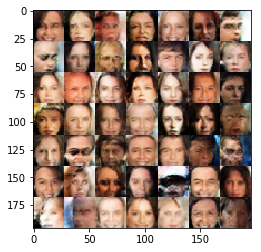

Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 1.2247
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.5539... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.6007


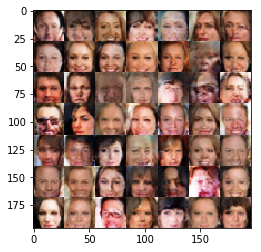

Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.3993
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.5245
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.7215


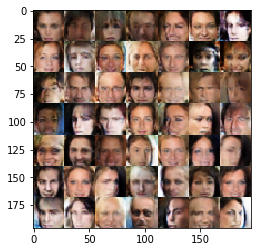

Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 1.0576
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.5237
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.5850


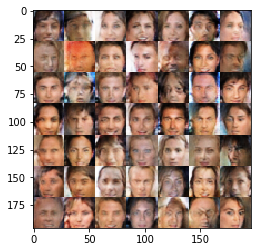

Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 2.2936
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.7462... Generator Loss: 0.4429
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.9247... Generator Loss: 0.3962
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.4922


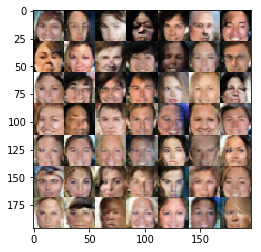

Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.7631... Generator Loss: 0.4159
Epoch 1/1... Discriminator Loss: 1.6516... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 1.5792... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.9617


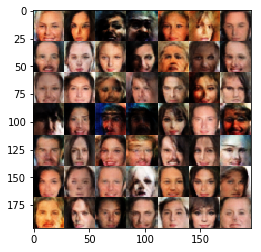

Epoch 1/1... Discriminator Loss: 1.6389... Generator Loss: 0.4707
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 2.0799... Generator Loss: 0.3682
Epoch 1/1... Discriminator Loss: 1.6473... Generator Loss: 0.4446
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.8603
Epoch 1/1... Discriminator Loss: 1.6704... Generator Loss: 0.4554


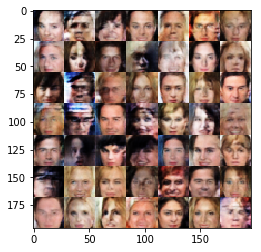

Epoch 1/1... Discriminator Loss: 1.5586... Generator Loss: 0.4881
Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 1.8242... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 1.5847... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.6240


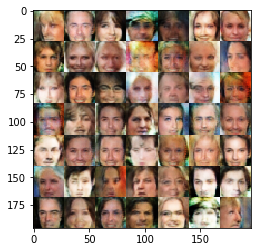

Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.9408... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 1.5771... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.9852
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.6583


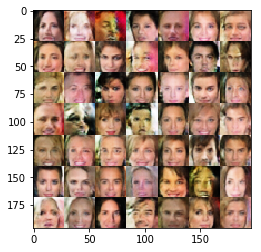

Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.6176... Generator Loss: 0.4623
Epoch 1/1... Discriminator Loss: 1.5506... Generator Loss: 0.4808
Epoch 1/1... Discriminator Loss: 1.7574... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 0.9207
Epoch 1/1... Discriminator Loss: 2.0620... Generator Loss: 0.3819


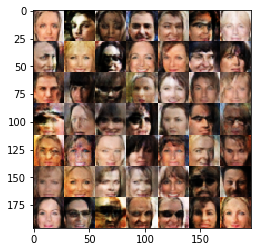

Epoch 1/1... Discriminator Loss: 0.7199... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 1.3532
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 2.1785
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 2.3116
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.6557
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.5143


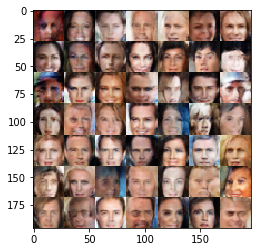

Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 2.2272
Epoch 1/1... Discriminator Loss: 1.6570... Generator Loss: 0.4764
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.3818
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 0.6881... Generator Loss: 1.6585
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 0.7716


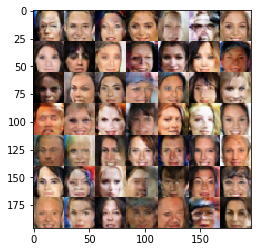

Epoch 1/1... Discriminator Loss: 0.7562... Generator Loss: 1.5094
Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 1.2728
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 1.4794
Epoch 1/1... Discriminator Loss: 1.6723... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 1.5652
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 0.8819


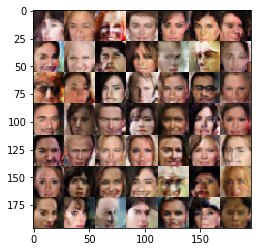

Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.6744
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.5834


In [99]:
#First attempt of hyperparameters: same as MNIST; 3 layers on the generator&discriminator network
#batch_size = 64
#z_dim = 100
#learning_rate = 0.0002
#beta1 = 0.5
#alpha = 0.2
#The results were faces (I could tell it was people!) but they were somewhat blurry. So, I kept these
#hyperparameters the same but added another convolutional layer both to discriminator and generator to see if
#adding more capacity helped

#Second attempt of hyperparameters: same as MNIST; 4 layers on the generator&discriminator network.
#batch_size = 64
#z_dim = 100
#learning_rate = 0.0002
#beta1 = 0.5
#alpha = 0.2
#With these parameters the images seemed a bit richer (more features in peoples faces) but progress was very slow
# decided to increase the learning_rate by an order of magnitude to see if it helped

#Third attempt of hyperparameters: same as before; but with learning_rate much larger
#batch_size = 64
#z_dim = 100
#learning_rate = 0.002
#beta1 = 0.5
#alpha = 0.2

#Fourth attempt of hyperparameters: learning_rate too high caused loss to jump around too much. Increased 
#only slightly. Decreased the batch_size to 48 (halfway between 32 and 64)
#batch_size = 48
#z_dim = 100
#learning_rate = 0.0005
#beta1 = 0.5
#alpha = 0.2


#Fifth attempt of hyperparameters: Increased batch size to 56 since there was no noticeable improvement.
# reduced  z_dim to 80 and reduced the learning rate futher more. Tweaked exponecial decay to be smaller
#batch_size = 56
#z_dim = 80
#learning_rate = 0.0004
#beta1 = 0.4
#alpha = 0.2


#6th attempt of hyperparameters: Increased batch size to 64 since there was no noticeable improvement.
# increased z_dim back to 100 and reduced the learning rate futher more. Tweaked exponecial decay to be smaller
#batch_size = 64
#z_dim = 100
#learning_rate = 0.0004
#beta1 = 0.6
#alpha = 0.2
#Produced very noisy images to reducing learning rate and sample size in next iteration

#7th iteration: adding xavier_initlization, reduced the learning_rate to 0.0001 and reduced the batch_size 
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode,alpha=alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.